In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib.colors import Normalize
import pandas as pd
import numpy as np
import os
from pathlib import Path
from variability_utils import *
plt.rcParams['figure.dpi'] = 120

In [17]:
data_path = os.environ.get("FLYVIS_DATA_PATH", "data")
data_path = os.path.expanduser(data_path)
p = Path(data_path)
p.mkdir(parents=True, exist_ok=True)

is_empty = not any(p.iterdir())

if is_empty:
    # !python -m pip -q install -U gdown # uncomment if gdown is not installed
    !gdown --folder "https://drive.google.com/drive/folders/1B91un2NpSaKSHol8KmfpQCB2KeGnS4pj" -O "{data_path}"
else:
    print(f"Data directory not empty, skipping download: {data_path}")



Data directory not empty, skipping download: data


In [27]:
codex_meta = pd.read_csv(os.path.join(data_path, 'column_assignment.csv'))
codex_meta["root_id"] = pd.to_numeric(codex_meta["root_id"], errors="coerce") 
root_ids = codex_meta["root_id"].dropna().astype("int64").to_numpy()
fafb_meta = pd.read_feather(os.path.join(data_path, 'fafb_783_meta.feather'))
fafb_meta["fafb_783_id"] = pd.to_numeric(fafb_meta["fafb_783_id"], errors="coerce") 
fafb_meta["fafb_783_id"] = fafb_meta["fafb_783_id"].dropna().astype("int64")

edge_df = pd.read_csv(os.path.join(data_path, 'connections_princeton.csv')) #threshold synapses
edge_df = edge_df[edge_df['syn_count'] >= 3]

In [28]:
edge_df['syn_count'].min()

np.int64(3)

In [29]:
nodes_R = build_nodes_coords_for_side("right",fafb_meta, codex_meta, root_ids)
nodes_R = nodes_R.drop(columns=['cell_function', 'cell_function_detailed',	'body_part_sensory', 'body_part_effector'])


In [49]:
## Define celltype input vector
ctype = 'Tm9'
type_nodes = nodes_R[nodes_R['cell_type'] == ctype].reset_index(drop=True)

edge_df_type = edge_df[edge_df['post_root_id'].isin(type_nodes['fafb_783_id'])].reset_index(drop=True) #all input synapses to Tm9 cells
edge_df_type['presyn_type'] = edge_df_type['pre_root_id'].map(nodes_R.set_index('fafb_783_id')['cell_type']) #map presynaptic cell types
edge_df_type.dropna(subset=['presyn_type'], inplace=True)
total_input_types = np.sort(edge_df_type['presyn_type'].unique()) #sort alphabetically
total_input_types.sort()
print(len(total_input_types)) #dimension of input vector
print(total_input_types)

16
['C2' 'C3' 'L1' 'L2' 'L3' 'L4' 'Mi1' 'Mi4' 'Mi9' 'T1' 'T2a' 'T5b' 'Tm1'
 'Tm2' 'Tm20' 'Tm9']


In [55]:
x = type_nodes[type_nodes['column_id'] == 624]
y = edge_df_type[edge_df_type['post_root_id'].isin(x['fafb_783_id'])]
y

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,presyn_type
1337,720575940623511532,720575940612881381,ME_R,29,ACH,L3


In [90]:
import numpy as np
from scipy.stats import entropy


raw_counts = np.array([1, .1, .1, .1])
# raw_counts = np.array([10,10,10,10])
 
print("Theoretical max entropy:", np.log2(len(raw_counts)))  # log2(4) = 2 bits
shannon_val = entropy(raw_counts, base=2) 
print(f"Entropy: {shannon_val} bits")
print(f"Normalized Entropy: {shannon_val/np.log2(len(raw_counts))}")
print(f"Delta to max: {np.log2(len(raw_counts)) - shannon_val} bits")

Theoretical max entropy: 2.0
Entropy: 1.145110414381583 bits
Normalized Entropy: 0.5725552071907914
Delta to max: 0.8548895856184171 bits


In [51]:

## Will later do this vector based
def input_vector_for_cell(cell_id):
    input_syns = edge_df_type[edge_df_type['post_root_id'] == cell_id]
    fv = np.array([0]*len(total_input_types))
    for i, itype in enumerate(total_input_types):
        syn_count = input_syns[input_syns['presyn_type'] == itype]['syn_count'].sum()
        # print(f"Cell {cell_id} has {syn_count} synapses from {itype}")
        fv[i] = syn_count
    return fv

type_nodes['input_vector'] = type_nodes['fafb_783_id'].apply(lambda cid: input_vector_for_cell(cid))

# x['input_vector'] = x['fafb_783_id'].apply(lambda cid: input_vector_for_cell(cid))


In [52]:
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Define a safe wrapper (handles cases where a cell might have 0 synapses total)
def get_entropy(vec):
    if np.sum(vec) == 0:
        return 0
    return entropy(vec, base=2) # Base 2 gives units in "bits"

# Apply the function to your new column
type_nodes['shannon_entropy'] = type_nodes['input_vector'].apply(get_entropy)
min = type_nodes['shannon_entropy'].min(); max = type_nodes['shannon_entropy'].max()

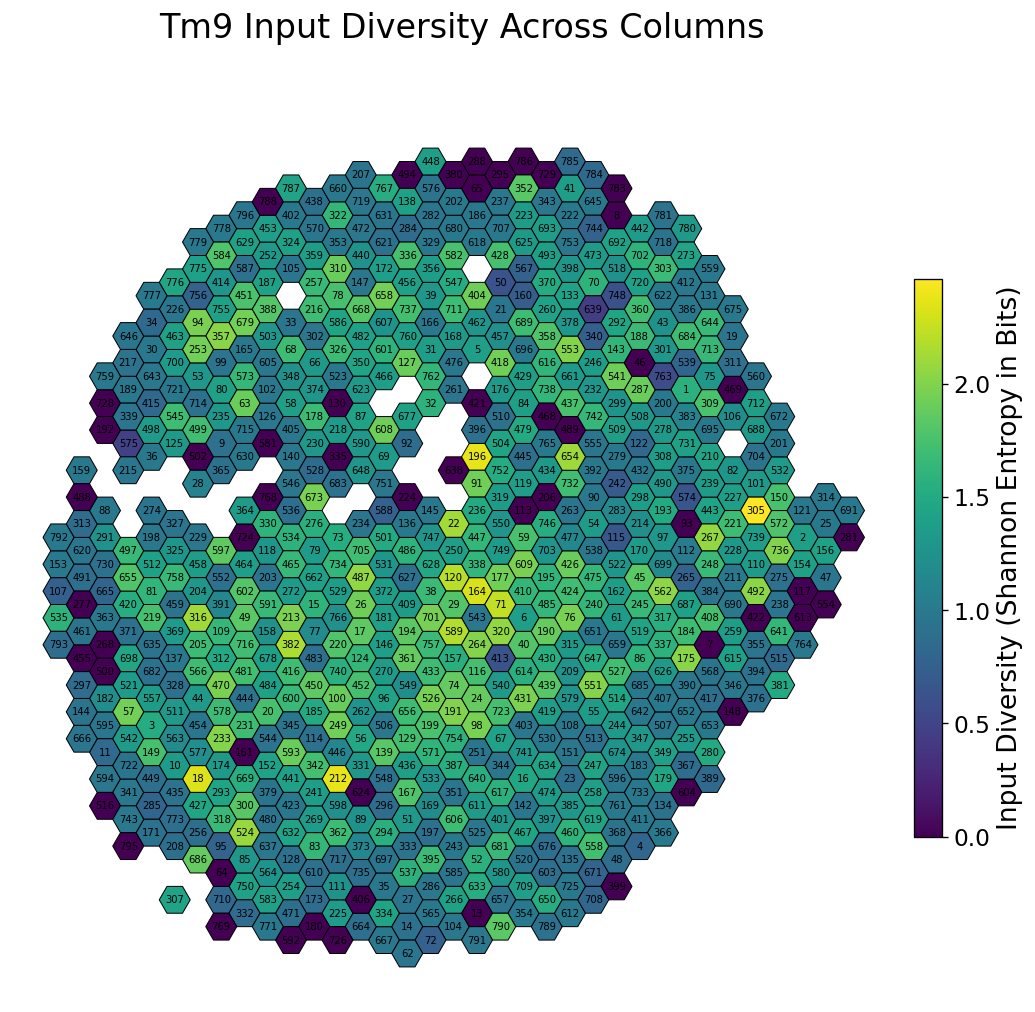

In [53]:
# colpos = nodes_R[["column_id", "p", "q"]].drop_duplicates("column_id").copy()
colpos = type_nodes[["column_id", "p", "q"]].drop_duplicates("column_id").copy()

x, y = pq_to_xy(colpos["p"].to_numpy(), colpos["q"].to_numpy(), hexsize=1.0)
x *=-1; y *= -1  # mirror to match FAFB orientation
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle(f"{ctype} Input Diversity Across Columns", 
             fontsize=20, x=0.5,y=0.95)
ax.set_aspect("equal")
ax.axis("off")

hexsize = 1.0
for xi, yi, cid in zip(x, y, colpos["column_id"].to_numpy()):
    H = type_nodes[type_nodes["column_id"] == cid]["shannon_entropy"].to_numpy()
    if len(H) == 0:
        H_val = 0.0
    else:
        H_val = H[0]
    norm = Normalize(vmin=min, vmax=max)
    cmap = plt.get_cmap("viridis")
    color = cmap(norm(H_val))
    hex_patch = RegularPolygon(
        (xi, yi), numVertices=6, radius=hexsize, orientation=np.pi/6,
        facecolor=color, edgecolor="black", linewidth=0.6
    )
    ax.add_patch(hex_patch)

    ax.text(xi, yi, str(cid), ha="center", va="center", fontsize=6)

# padding around the eye
pad = 3 * hexsize
ax.set_xlim(x.min()-pad, x.max()+pad)
ax.set_ylim(y.min()-pad, y.max()+pad)

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(mappable, ax=ax, fraction=0.03, pad=0.02)
cb.set_label("Input Diversity (Shannon Entropy in Bits)", fontsize=16)
cb.ax.tick_params(labelsize=14)
plt.show()
plt.show()

